In [1]:
import json
from datetime import datetime, timedelta
from glob import iglob
from pathlib import Path
from pprint import pprint
from itables import init_notebook_mode, show
import humanize
import janitor
import numpy as np
import pandas as pd
import pyperclip
from funcy import project


def get_best_score(path: Path):
    exp = json.loads(path.read_text())
    # print_keys_recursively(exp)

    # print(path)

    for i in exp["iterations"]:
        for c in i["candidates"]:
            # print(c.get("candidate", {}).get("prompt_pattern"))
            # print(c)
            results = c.get("results", [])
            # print(results)
            ress = np.array([int(k["correct"]) for k in results])
            # print(
            #     c.get("candidate", {}).get("prompt_pattern"),
            #     c.get("candidate", {}).get("num_demonstrations"),
            #     np.mean(ress),
            # )
            # break
        # print("----")

    if "final_iteration" not in exp:
        # print("Broken:", path)
        return None

    final = exp["final_iteration"]
    # project(
    #     exp["final_iteration"],
    #     ["ending_test_set_size", "timestamp_before", "timestamp_after", "score"],
    # )

    exceptions = sum(
        int(r["exception"] != "None") for r in final["candidate"]["results"]
    )
    # print("Num exceptions:", exceptions)

    timestamp_delta = final["timestamp_after"] - final["timestamp_before"]
    delta = timedelta(seconds=timestamp_delta)
    runtime_str = humanize.naturaldelta(delta)
    # print("Runtime:", runtime_str)  # Output: "a day and 3 hours"
    # print("Ending test set size:", f"{final['ending_test_set_size']:,}")
    # print("Score:", f"{final['score']:.2%}")

    if "gsm8k" in path.name:
        bench = "gsm8k"
    elif "fever" in path.name:
        bench = "fever"
    else:
        bench = None

    return {
        "file": path.name,
        "dataset": exp["config"].get("raw_config", {}).get("benchmark", None) or bench,
        "exceptions": exceptions,
        "results_len": len(final["candidate"]["results"]),
        "timestamp_start": final["timestamp_before"],
        "timestamp_end": final["timestamp_after"],
        "runtime": delta,
        "runtime_str": runtime_str,
        "ending_test_set_size": final["ending_test_set_size"],
        "eval_set_indices_len": len(final["eval_set_indices"]),
        "score": final["score"],
        "model": final["candidate"]["candidate"]["model"],
        "pattern": final["candidate"]["candidate"]["prompt_pattern"],
        "num_demonstrations": final["candidate"]["candidate"].get("num_demonstrations", 0),
    }

In [ ]:
# full opt run granite 3 8b
get_best_score(Path("experiments/granite_3_8b_instruct_gsm8k_opt_sxzr8erk.json"))

In [ ]:
# fever parse
get_best_score(
    Path("experiments/granite_3_8b_instruct_fever_zero_shot_parse_q2nw53am.json")
)

In [ ]:
# fever no parse
get_best_score(Path("experiments/granite_3_8b_instruct_fever_zero_shot_mdwk1ymn.json"))

In [ ]:
# gsm hard
get_best_score(
    Path("experiments/granite_3_8b_instruct_gsmhard_zero_shot_1phaxl0n.json")
)

In [17]:
def get_exp_df(glob: str = "*.json"):
    exp_path = Path("experiments")
    exp_results = []
    for x in exp_path.glob(glob):
        # print("------")
        res = get_best_score(x)
        if res is None:
            continue
        exp_results.append(res)
        # print("------")
        # break

    exp_df = pd.DataFrame.from_records(exp_results)

    # exp_df = exp_df[exp_df.eval_set_indices_len>1000]
    exp_df = exp_df[~exp_df.model.isin(["watsonx/ibm/granite-13b-instruct-v2"])]

    columns_to_keep = [
        "dataset",
        "model",
        "score",
        # "exceptions",
        "num_demonstrations",
        "pattern",
    ]

    # Group by dataset and model, and keep the row with the max score
    df_filtered = exp_df.loc[
        exp_df.groupby(["dataset", "model", "num_demonstrations"])["score"].idxmax(), columns_to_keep
    ].reset_index(drop=True)

    # Mapping model names to their pretty versions
    model_name_mapping = {
        "watsonx/ibm/granite-20b-code-instruct": "Granite 20B Code",
        "watsonx_text/ibm/granite-13b-instruct-v2": "Granite 13B Instruct V2",
        "watsonx/ibm/granite-3-8b-instruct": "Granite 3 8B",
        "watsonx/ibm/granite-34b-code-instruct": "Granite 34B Code",
        "watsonx/meta-llama/llama-3-1-70b-instruct": "LLaMA3 70B",
        "watsonx/meta-llama/llama-3-1-8b-instruct": "LLaMA3 8B",
    }

    # Apply model name mapping
    df_filtered["model"] = df_filtered["model"].map(
        lambda x: model_name_mapping.get(x, x)
    )

    # Generate LaTeX table using formatters
    latex_table = df_filtered.to_latex(
        index=False,
        column_format="l l r r",
        caption="Results Table",
        label="tab:results",
        escape=False,
        formatters={
            "score": "{:,.2%}".format,  # lambda x: f"{x:.2%}"  # Format score as percentage with 2 decimal places
        },
    )
    # print(latex_table)
    return df_filtered


def show_df(df):
    with pd.option_context("display.float_format", "{:,.2%}".format):
        show(df)


zeroshot_df = get_exp_df("*_zero_shot_*.json")
opt_df = get_exp_df("*_opt_*.json")

df_to_show = zeroshot_df[zeroshot_df.model.isin(opt_df.model)]
show_df(df_to_show)
show_df(opt_df)

In [20]:
df_to_show1 = df_to_show.copy().drop(["num_demonstrations"], axis=1)
df_to_show1["zeroshot score"] = df_to_show1["score"].map(lambda x: f"{x:,.2%}")
df_to_show1 = df_to_show1.drop(["score", "pattern"], axis=1)
df_to_show1 = df_to_show1.merge(right=opt_df, on=["dataset", "model"])
df_to_show1["opt score"] = df_to_show1["score"].map(lambda x: f"{x:,.2%}")
df_to_show1 = df_to_show1.drop(["score"], axis=1)
df_to_show1 = df_to_show1.rename_column("pattern", "best pattern")

print(df_to_show1.to_markdown())

|    | dataset   | model                   | zeroshot score   |   num_demonstrations | best pattern   | opt score   |
|---:|:----------|:------------------------|:-----------------|---------------------:|:---------------|:------------|
|  0 | evalplus  | Granite 20B Code        | 57.59%           |                    0 | cot            | 57.59%      |
|  1 | evalplus  | Granite 3 8B            | 68.75%           |                    0 | cot            | 65.62%      |
|  2 | evalplus  | Granite 34B Code        | 58.93%           |                    0 | cot            | 58.48%      |
|  3 | evalplus  | LLaMA3 70B              | 73.21%           |                    0 | cot            | 69.20%      |
|  4 | evalplus  | LLaMA3 8B               | 61.16%           |                    0 | cot            | 60.71%      |
|  5 | evalplus  | Granite 13B Instruct V2 | 10.71%           |                    3 | react          | 18.75%      |
|  6 | fever     | Granite 20B Code        | 39.55%     

/Users/claudio/.conda/envs/pdlnew/lib/python3.12/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


|    | dataset   | model                   | zeroshot score   |   num_demonstrations | best pattern   | opt score   |
|---:|:----------|:------------------------|:-----------------|---------------------:|:---------------|:------------|
|  0 | evalplus  | Granite 20B Code        | 57.59%           |                    0 | cot            | 57.59%      |
|  1 | evalplus  | Granite 3 8B            | 68.75%           |                    0 | cot            | 65.62%      |
|  2 | evalplus  | Granite 34B Code        | 58.93%           |                    0 | cot            | 58.48%      |
|  3 | evalplus  | LLaMA3 70B              | 73.21%           |                    0 | cot            | 69.20%      |
|  4 | evalplus  | LLaMA3 8B               | 61.16%           |                    0 | cot            | 60.71%      |
|  5 | evalplus  | Granite 13B Instruct V2 | 10.71%           |                    3 | react          | 18.75%      |
|  6 | fever     | Granite 20B Code        | 39.55%           |                    3 | cot            | 64.20%      |
|  8 | fever     | Granite 3 8B            | 78.22%           |                    5 | rewoo          | 79.00%      |
|  9 | fever     | Granite 34B Code        | 56.74%           |                    3 | cot            | 65.60%      |
| 10 | fever     | LLaMA3 70B              | 29.79%           |                    3 | cot            | 86.30%      |
| 11 | fever     | LLaMA3 8B               | 68.55%           |                    3 | cot            | 78.00%      |
| 12 | fever     | Granite 13B Instruct V2 | 6.54%            |                    3 | rewoo          | 75.40%      |
| 13 | gsm8k     | Granite 20B Code        | 68.75%           |                    0 | cot            | 68.70%      |
| 15 | gsm8k     | Granite 3 8B            | 74.41%           |                    5 | react          | 75.80%      |
| 16 | gsm8k     | Granite 34B Code        | 72.17%           |                    0 | cot            | 72.10%      |
| 17 | gsm8k     | LLaMA3 70B              | 82.03%           |                    5 | cot            | 94.80%      |
| 19 | gsm8k     | LLaMA3 8B               | 78.12%           |                    3 | cot            | 84.80%      |
| 21 | gsm8k     | Granite 13B Instruct V2 | 23.24%           |                    5 | cot            | 30.30%      |

| Task   | Granite 3 8B Best      | LLama3 8B Best      |
|--------|----------------------|----------------------|
| **GSM8k**  | 5 ReAct (75.2%)  | 3S CoT (84.8%)  |
|        | vs  | vs  |
|        | 0S CoT (74.4%)  | 0S CoT (78.12%)  |
| **FEVER**  | 78.22% 0S CoT  | 3S CoT (78%)  |
|        |   | vs  |
|        |   | 0S CoT (68.55%)  |
| **MBPP**  | 68.75% 0S  | 60.27% 0S  |

In [ ]:
show(exp_df)

In [ ]:
# csv = exp_df.to_csv(None)
# exp_df.to_csv("results_feb2.csv")
# pyperclip.copy(csv)

In [ ]:
columns_to_keep = ["dataset", "model", "score", "exceptions"]

# Group by dataset and model, and keep the row with the max score
df_filtered = exp_df.loc[
    exp_df.groupby(["dataset", "model"])["score"].idxmax(), columns_to_keep
].reset_index(drop=True)

# Mapping model names to their pretty versions
model_name_mapping = {
    "watsonx/ibm/granite-20b-code-instruct": "Granite 20B Code",
    "watsonx_text/ibm/granite-13b-instruct-v2": "Granite 13B Instruct V2",
    "watsonx/ibm/granite-3-8b-instruct": "Granite 3 8B",
    "watsonx/ibm/granite-34b-code-instruct": "Granite 34B Code",
    "watsonx/meta-llama/llama-3-1-70b-instruct": "LLaMA3 70B",
    "watsonx/meta-llama/llama-3-1-8b-instruct": "LLaMA3 8B",
}

# Apply model name mapping
df_filtered["model"] = df_filtered["model"].map(lambda x: model_name_mapping.get(x, x))

with pd.option_context("display.float_format", "{:,.2%}".format):
    show(df_filtered)

# Generate LaTeX table using formatters
latex_table = df_filtered.to_latex(
    index=False,
    column_format="l l r r",
    caption="Results Table",
    label="tab:results",
    escape=False,
    formatters={
        "score": "{:,.2%}".format,  # lambda x: f"{x:.2%}"  # Format score as percentage with 2 decimal places
    },
)
print(latex_table)

In [ ]:
with pd.option_context("display.float_format", "{:,.2%}".format):
    show(df_filtered)

In [ ]:
def print_keys_recursively(d, parent_key=""):
    """
    Recursively traverses a dictionary and prints all keys.

    :param d: The dictionary to traverse.
    :param parent_key: Used to show the hierarchy of nested keys (optional).
    """
    if isinstance(d, dict):
        for key, value in d.items():
            if key == "1candidates":
                continue
            full_key = f"{parent_key}.{key}" if parent_key else key
            print(full_key)
            if isinstance(value, dict):
                print_keys_recursively(value, full_key)
            elif isinstance(value, list):
                for i, item in enumerate(value):
                    if isinstance(item, dict):
                        print_keys_recursively(item, f"{full_key}[{i}]")
                    if key in ["candidates", "results", "iterations"]:
                        break
    else:
        print("Provided input is not a dictionary.")


print_keys_recursively(exp)

In [ ]:
from math import ceil, log2
import sys


num_candidates = 4
starting_test_set_size = 2
ending_test_set_size = 32

num_iterations = ceil(log2(num_candidates))
test_set_multiplier = 2
# test_set_multiplier = ceil(
#     (ending_test_set_size / starting_test_set_size)
#     ** (1 / (num_iterations - 1)),
# )
total = max(num_iterations, 1) * num_candidates * starting_test_set_size

current_test_set_size = starting_test_set_size
max_iterations = sys.maxsize
candidates = [0 for _ in range(num_candidates)]
progress = 0
for iteration in range(max_iterations):
    if iteration > num_iterations:
        print("Exceeded predicted iterations!!!")
    if current_test_set_size < 1:
        print("Starting test set less than 1!!!")
        break

    selected_candidates = candidates[:num_candidates]
    progress += (iteration) * (num_candidates * current_test_set_size)
    print(iteration + 1, ": ", progress, "/", total)
    print(
        f"{len(selected_candidates)} candidates left, test set size: {current_test_set_size}"
    )

    num_candidates = max(1, num_candidates // 2)
    scores = selected_candidates[:num_candidates]
    candidates = [r for r in scores]
    # Step 4: Multiply the test set size for the next iteration
    current_test_set_size = min(
        current_test_set_size * test_set_multiplier,
        ending_test_set_size,
    )
    # If only one candidate is left, stop
    if len(candidates) == 1:
        print("Only 1 candidate left. Ending...")
        break
# 16/8

In [ ]:
1 // 2

In [ ]:
from math import log2

In [ ]:
log2(100)

In [ ]:
2**4

In [ ]:
2**10

In [ ]:
100
50
25
12
6
3
1

In [ ]:
128
64
32
16
8
4
2
1

In [11]:
import seaborn as sns
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import iglob
from funcy import project, omit

In [ ]:
for exp_file in iglob("experiments/*.json"):
    exp = json.loads(Path(exp_file).read_text())
    if "results" in exp:
        # print(exp.keys())
        # print(omit(exp["results"], ["candidates"]))
        # print(exp["results"]["candidates"][-1].keys())
        print(exp_file)
        print(exp["results"]["candidates"][-1]["candidate"])
        print(exp["results"]["candidates"][-1]["metric"])


In [ ]:
exp = json.loads(Path("experiments/opdkb4tq.json").read_text())

In [ ]:
exp["config"]

In [ ]:
(exp["iterations"][0]["candidates"])

In [ ]:
exp["iterations"][5]["candidates"][0]

In [ ]:
len(exp["iterations"][0]["candidates"][0]["results"])

In [ ]:
[
    exp["iterations"][-1]["candidates"][i]["candidate"]["prompt_pattern"]
    for i in range(3)
]

In [ ]:
[exp["iterations"][-1]["candidates"][i]["metric"] for i in range(3)]

In [ ]:
exp["config"]

In [47]:
results = []

for exp_path in Path("experiments").glob("*_opt_*.json"):
    exp = json.loads(exp_path.read_text())
    uuids = {k: [] for k in exp["iterations"][0]["selected_candidates_uuids"]}
    x = []
    y = []
    y_avg = []
    for j, iteration in enumerate(exp["iterations"]):
        x.append(iteration["timestamp"])
        for i in iteration["candidates"]:
            uuids[i["candidate"]["uuid"]].append(i["metric"])
            results.append(
                {
                    "exp": exp_path.stem,
                    "iteration": j,
                    "uuid": i["candidate"]["uuid"],
                    "metric": i["metric"],
                    "test_set": len(i["results"]),
                    "prompt_pattern": i["candidate"].get("prompt_pattern", None),
                    "system_prompt": i["candidate"].get("system_prompt", None),
                    "num_demonstrations": i["candidate"].get(
                        "num_demonstrations", None
                    ),
                }
            )
        scores = [i["metric"] for i in iteration["candidates"]]
        max_score = min(scores)
        avg = np.mean(scores)
        y.append(max_score)
        y_avg.append(avg)

df = pd.DataFrame(results)
df[(df.num_demonstrations == 0) & (df.prompt_pattern != "cot")]

,exp,iteration,uuid,metric,test_set,prompt_pattern,system_prompt,num_demonstrations
201,granite_3_8b_instruct_fever_opt_drths2r9,0,kyt2ikjl,0.000,16,rewoo,granite_llama,0.0
589,llama_8b_gsm8k_opt_44bh84oa,0,dhrk2jyo,0.000,16,rewoo,granite_llama,0.0
784,granite_3_8b_instruct_gsm8k_opt_pbd2ckbk,0,2y8ncnkc,0.000,8,react,granite_tools,0.0
880,granite_3_8b_instruct_gsm8k_opt_sxzr8erk,0,9pnu77h2,0.000,8,rewoo,None,0.0
881,granite_3_8b_instruct_gsm8k_opt_sxzr8erk,0,urupf738,0.375,8,react,None,0.0
883,granite_3_8b_instruct_gsm8k_opt_sxzr8erk,0,7wgbb7lb,0.000,8,rewoo,None,0.0
885,granite_3_8b_instruct_gsm8k_opt_sxzr8erk,0,h7vqayqt,0.000,8,rewoo,None,0.0
886,granite_3_8b_instruct_gsm8k_opt_sxzr8erk,0,qvc4zoaw,0.000,8,rewoo,None,0.0
889,granite_3_8b_instruct_gsm8k_opt_sxzr8erk,0,ms21px6a,0.250,8,react,None,0.0
890,granite_3_8b_instruct_gsm8k_opt_sxzr8erk,0,wgrjg8lf,0.000,8,rewoo,None,0.0


In [62]:
exp = json.loads(
    Path("experiments/granite_3_8b_instruct_gsm8k_opt_sxzr8erk.json").read_text()
)
uuids = {k: [] for k in exp["iterations"][0]["selected_candidates_uuids"]}
results = []
x = []
y = []
y_avg = []
for j, iteration in enumerate(exp["iterations"]):
    x.append(iteration["timestamp"])
    for i in iteration["candidates"]:
        uuids[i["candidate"]["uuid"]].append(i["metric"])
        results.append(
            {
                "iteration": j,
                "uuid": i["candidate"]["uuid"],
                "metric": i["metric"],
                "test_set": len(i["results"]),
                "prompt_pattern": i["candidate"].get("prompt_pattern", None),
                "system_prompt": i["candidate"].get("system_prompt", None),
                "num_demonstrations": i["candidate"].get("num_demonstrations", None),
            }
        )
    scores = [i["metric"] for i in iteration["candidates"]]
    max_score = min(scores)
    avg = np.mean(scores)
    y.append(max_score)
    y_avg.append(avg)

df = pd.DataFrame(results)
# fig = sns.lineplot(df, x="iteration", y="metric")
# fig.set_title("FEVER Iteration vs Accuracy")
# fig.set_ylabel("Accuracy")
# fig.set_xlabel("Iteration")
df[df.num_demonstrations == 0]

,iteration,uuid,metric,test_set,prompt_pattern,system_prompt,num_demonstrations
0,0,9pnu77h2,0.000000,8,rewoo,None,0
1,0,urupf738,0.375000,8,react,None,0
3,0,7wgbb7lb,0.000000,8,rewoo,None,0
5,0,h7vqayqt,0.000000,8,rewoo,None,0
6,0,qvc4zoaw,0.000000,8,rewoo,None,0
8,0,pmv1q5gx,0.875000,8,cot,None,0
9,0,ms21px6a,0.250000,8,react,None,0
10,0,wgrjg8lf,0.000000,8,rewoo,None,0
12,0,zbf67kxp,0.000000,8,rewoo,None,0
13,0,prb1egfl,0.375000,8,react,None,0


,iteration,uuid,metric,test_set,prompt_pattern,system_prompt,num_demonstrations
3,0,lfwxhydu,0.625000,16,cot,llama3,0
100,1,lfwxhydu,0.625000,32,cot,llama3,0
150,2,lfwxhydu,0.615385,39,cot,llama3,0
175,3,lfwxhydu,0.615385,39,cot,llama3,0
187,4,lfwxhydu,0.615385,39,cot,llama3,0
193,5,lfwxhydu,0.615385,39,cot,llama3,0


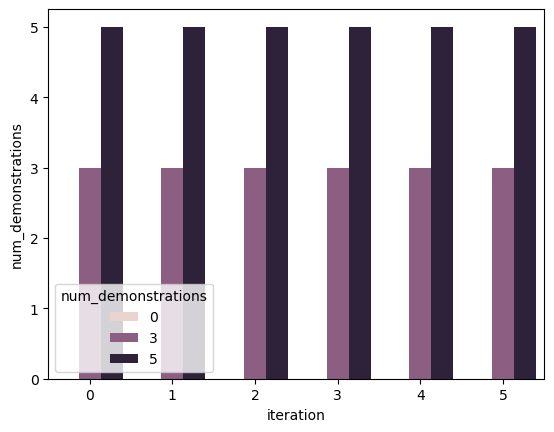

In [34]:
fig = sns.barplot(
    df, x="iteration", hue="num_demonstrations", y="num_demonstrations"
)  # , y="num_demonstrations")
# fig.set_title("FEVER Iteration vs Accuracy")
# fig.set_ylabel("Accuracy")
# fig.set_xlabel("Iteration")

In [13]:
df

,g0qhl2zo,dhrk2jyo,t0is50lv,fbhirxgl,z6ai0w5s,yyivcdlp,6f8dy8dr,ql6yc5b1,oz62iktr,f6j5xdp3,...,10mqj6yn,v93t56u1,lvbxihz8,m96mk8wr,xqk5vao6,0gew0xz9,v16ci744,7hceam9e,324flobo,l0jfjvl8
0,0.62500,0.0,1.000000,0.87500,0.62500,0.7500,0.4375,0.1875,0.5625,0.25,...,0.0,0.68750,0.5,0.7500,0.93750,0.937500,0.0,0.81250,0.93750,0.93750
1,0.59375,NaN,1.000000,0.93750,0.53125,0.6875,NaN,NaN,NaN,NaN,...,NaN,0.59375,NaN,0.6875,0.93750,0.937500,NaN,0.84375,0.96875,0.93750
2,NaN,NaN,0.937500,0.90625,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.90625,0.890625,NaN,NaN,0.90625,0.90625
3,NaN,NaN,0.937500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.929688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.927734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
results

In [14]:
df = pd.DataFrame(results)

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in uuids.items()]))

# Plot the DataFrame
plt.figure(figsize=(10, 6))
df.plot(marker="o", legend=False)
plt.title("Accuracy vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0.75, 0.86)
plt.show()

In [ ]:
df

Text(0.5, 0, 'Iteration')

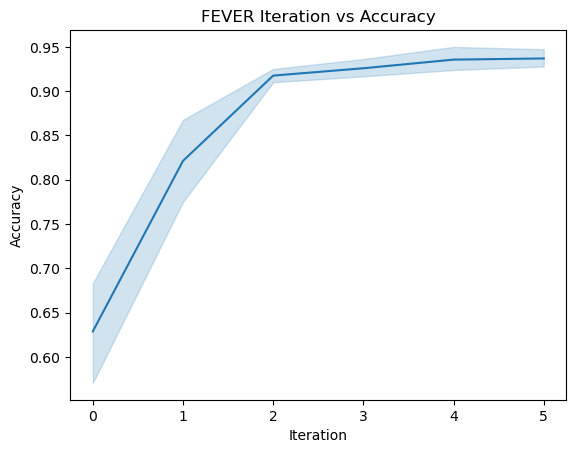

In [15]:
fig = sns.lineplot(df, x="iteration", y="metric")
fig.set_title("FEVER Iteration vs Accuracy")
fig.set_ylabel("Accuracy")
fig.set_xlabel("Iteration")

In [ ]:
fig = sns.lineplot(df, x="iteration", y="metric")
fig.set_title("FEVER Iteration vs Accuracy")
fig.set_ylabel("Accuracy")
fig.set_xlabel("Iteration")

In [ ]:
import json
from pathlib import Path
from glob import iglob

In [ ]:
def get_best_score(filename):
    exp = json.loads(Path(filename).read_text())  # (Path("experiments") / filename)
    # print(exp.keys())
    # print(exp["config"].keys())
    # print(exp["config"]["candidates"])
    # print(exp["config"]["thread_class"])
    # print(exp["iterations"][-1].keys())
    last = exp["iterations"][-1]
    print(filename)
    print_keys_recursively(exp)
    print(exp["final_iteration"]["score"])  # .keys())
    if last["current_test_set_size"] != 1000:
        return
    # print(last.keys())
    print("test set size", last["current_test_set_size"])
    print("num cand", last["num_candidates"])
    for cand in last["candidates"]:
        print(cand["metric"], cand["candidate"])

    print(last["timestamp"] - exp["config"]["start_time"])
    # print(last["candidates"][0].keys())
    print(last["candidates"][0]["candidate"])
    # print(last["candidates"][0]["metric"])


exps = [
    f
    for f in iglob("experiments/*_evalplus_opt_*.json")
    # "llama_8b_fever_zero_shot_fk29b615.json",
    # "llama_70b_fever_zero_shot_m2rhguxu.json",
    # "granite_13b_instruct_fever_zero_shot_h8svlwbk.json",
    # "granite_20b_code_instruct_fever_zero_shot_i6k3wluh.json",
    # "granite_34b_code_instruct_fever_zero_shot_rj0b48oe.json",
    # "llama_8b_fever_opt_vnxho2i8.json",
    # "llama_70b_fever_opt_i8ulhovz.json",
    # "granite_13b_instruct_fever_opt_teso7yli.json",
    # "granite_20b_code_instruct_fever_opt_c7vxbogl.json",
    # "granite_34b_code_instruct_fever_opt_fnpdojj1.json",
]
for x in exps:
    # print(x)
    get_best_score(x)
    print("-----")

In [ ]:
def get_best_score(filename):
    exp = json.loads(Path(filename).read_text())  # (Path("experiments") / filename)
    # print(exp.keys())
    # print(exp["config"].keys())
    # print(exp["config"]["candidates"])
    # print(exp["config"]["thread_class"])
    # print(exp["iterations"][-1].keys())
    last = exp["iterations"][-1]
    print(filename)
    print(exp["final_iteration"]["score"])  # .keys())
    if last["current_test_set_size"] != 1000:
        return
    # print(last.keys())
    print("test set size", last["current_test_set_size"])
    print("num cand", last["num_candidates"])
    for cand in last["candidates"]:
        print(cand["metric"], cand["candidate"])

    print(last["timestamp"] - exp["config"]["start_time"])
    # print(last["candidates"][0].keys())
    print(last["candidates"][0]["candidate"])
    # print(last["candidates"][0]["metric"])


exps = [
    f
    for f in iglob("experiments/*_fever_*.json")
    # "llama_8b_fever_zero_shot_fk29b615.json",
    # "llama_70b_fever_zero_shot_m2rhguxu.json",
    # "granite_13b_instruct_fever_zero_shot_h8svlwbk.json",
    # "granite_20b_code_instruct_fever_zero_shot_i6k3wluh.json",
    # "granite_34b_code_instruct_fever_zero_shot_rj0b48oe.json",
    # "llama_8b_fever_opt_vnxho2i8.json",
    # "llama_70b_fever_opt_i8ulhovz.json",
    # "granite_13b_instruct_fever_opt_teso7yli.json",
    # "granite_20b_code_instruct_fever_opt_c7vxbogl.json",
    # "granite_34b_code_instruct_fever_opt_fnpdojj1.json",
]
for x in exps:
    # print(x)
    get_best_score(x)
    print("-----")

In [ ]:
def get_best_score(filename):
    exp = json.loads(Path(filename).read_text())  # (Path("experiments") / filename)
    # print(exp.keys())
    # print(exp["config"].keys())
    # print(exp["config"]["candidates"])
    # print(exp["config"]["thread_class"])
    # print(exp["iterations"][-1].keys())
    last = exp["iterations"][-1]
    if last["current_test_set_size"] != 1000:
        return
    # print(last.keys())
    print(filename)
    print("test set size", last["current_test_set_size"])
    print("num cand", last["num_candidates"])
    for cand in last["candidates"]:
        print(cand["metric"], cand["candidate"])

    print(last["timestamp"] - exp["config"]["start_time"])
    # print(last["candidates"][0].keys())
    print(last["candidates"][0]["candidate"])
    print("----")
    # print(last["candidates"][0]["metric"])


exps = [
    f
    for f in iglob("experiments_prev/*_gsm8k_zero_shot_*.json")
    # "llama_8b_fever_zero_shot_fk29b615.json",
    # "llama_70b_fever_zero_shot_m2rhguxu.json",
    # "granite_13b_instruct_fever_zero_shot_h8svlwbk.json",
    # "granite_20b_code_instruct_fever_zero_shot_i6k3wluh.json",
    # "granite_34b_code_instruct_fever_zero_shot_rj0b48oe.json",
    # "llama_8b_fever_opt_vnxho2i8.json",
    # "llama_70b_fever_opt_i8ulhovz.json",
    # "granite_13b_instruct_fever_opt_teso7yli.json",
    # "granite_20b_code_instruct_fever_opt_c7vxbogl.json",
    # "granite_34b_code_instruct_fever_opt_fnpdojj1.json",
]
for x in exps:
    # print(x)
    get_best_score(x)
    # print("-----")

In [ ]:
def get_best_score(filename):
    exp = json.loads(Path(filename).read_text())  # (Path("experiments") / filename)
    # print(exp.keys())
    # print(exp["config"].keys())
    # print(exp["config"]["candidates"])
    # print(exp["config"]["thread_class"])
    # print(exp["iterations"][-1].keys())
    last = exp["iterations"][-1]
    if last["current_test_set_size"] != 1000:
        return
    # print(last.keys())
    print(filename)
    print("test set size", last["current_test_set_size"])
    print("num cand", last["num_candidates"])
    for cand in last["candidates"]:
        print(cand["metric"], cand["candidate"])

    print(last["timestamp"] - exp["config"]["start_time"])
    # print(last["candidates"][0].keys())
    print(last["candidates"][0]["candidate"])
    print("----")
    # print(last["candidates"][0]["metric"])


exps = [
    f
    for f in iglob("experiments_prev/*_fever_zero_shot_*.json")
    # "llama_8b_fever_zero_shot_fk29b615.json",
    # "llama_70b_fever_zero_shot_m2rhguxu.json",
    # "granite_13b_instruct_fever_zero_shot_h8svlwbk.json",
    # "granite_20b_code_instruct_fever_zero_shot_i6k3wluh.json",
    # "granite_34b_code_instruct_fever_zero_shot_rj0b48oe.json",
    # "llama_8b_fever_opt_vnxho2i8.json",
    # "llama_70b_fever_opt_i8ulhovz.json",
    # "granite_13b_instruct_fever_opt_teso7yli.json",
    # "granite_20b_code_instruct_fever_opt_c7vxbogl.json",
    # "granite_34b_code_instruct_fever_opt_fnpdojj1.json",
]
for x in exps:
    # print(x)
    get_best_score(x)
    # print("-----")

In [ ]:
def get_best_score(filename):
    exp = json.loads(Path(filename).read_text())  # (Path("experiments") / filename)
    # print(exp.keys())
    # print(exp["config"].keys())
    # print(exp["config"]["candidates"])
    # print(exp["config"]["thread_class"])
    # print(exp["iterations"][-1].keys())
    last = exp["iterations"][-1]
    # if last["current_test_set_size"] != 1000:
    # return
    # print(last.keys())
    print(filename)
    print("test set size", last["current_test_set_size"])
    print("num cand", last["num_candidates"])
    m = sorted([c["metric"] for c in last["candidates"]])
    # for cand in last["candidates"]:
    # print(cand["metric"], cand["candidate"])
    print(max(m))
    print(last["timestamp"] - exp["config"]["start_time"])
    # print(last["candidates"][0].keys())
    print(last["candidates"][0]["candidate"])
    print("----")
    # print(last["candidates"][0]["metric"])


exps = sorted([f for f in iglob("experiments_prev/*_fever_opt_*.json")])
# "llama_8b_fever_zero_shot_fk29b615.json",
# "llama_70b_fever_zero_shot_m2rhguxu.json",
# "granite_13b_instruct_fever_zero_shot_h8svlwbk.json",
# "granite_20b_code_instruct_fever_zero_shot_i6k3wluh.json",
# "granite_34b_code_instruct_fever_zero_shot_rj0b48oe.json",
# "llama_8b_fever_opt_vnxho2i8.json",
# "llama_70b_fever_opt_i8ulhovz.json",
# "granite_13b_instruct_fever_opt_teso7yli.json",
# "granite_20b_code_instruct_fever_opt_c7vxbogl.json",
# "granite_34b_code_instruct_fever_opt_fnpdojj1.json",
# ]
for x in exps:
    # print(x)
    get_best_score(x)
    # print("-----")

In [ ]:
def get_best_score(filename):
    exp = json.loads(Path(filename).read_text())  # (Path("experiments") / filename)
    # print(exp.keys())
    # print(exp["config"].keys())
    # print(exp["config"]["candidates"])
    # print(exp["config"]["thread_class"])
    # print(exp["iterations"][-1].keys())
    last = exp["iterations"][-1]
    # if last["current_test_set_size"] != 1000:
    # return
    # print("set size", last["current_test_set_size"])
    # print(last.keys())
    print(filename)
    # print("test set size", last["current_test_set_size"])
    # print("num cand", last["num_candidates"])
    for cand in last["candidates"]:
        # print(cand.keys())
        print(cand["metric"])  # , cand["candidate"])
        res = [x["correct"] for x in cand["results"]]
        print("len", len(res))
        print("np mean", np.mean(res))

    print(last["timestamp"] - exp["config"]["start_time"])
    # print(last["candidates"][0].keys())
    print(last["candidates"][0]["candidate"])
    print("----")
    # print(last["candidates"][0]["metric"])


exps = sorted([f for f in iglob("experiments_prev/*_evalplus_zero_shot_*.json")])
# "llama_8b_fever_zero_shot_fk29b615.json",
# "llama_70b_fever_zero_shot_m2rhguxu.json",
# "granite_13b_instruct_fever_zero_shot_h8svlwbk.json",
# "granite_20b_code_instruct_fever_zero_shot_i6k3wluh.json",
# "granite_34b_code_instruct_fever_zero_shot_rj0b48oe.json",
# "llama_8b_fever_opt_vnxho2i8.json",
# "llama_70b_fever_opt_i8ulhovz.json",
# "granite_13b_instruct_fever_opt_teso7yli.json",
# "granite_20b_code_instruct_fever_opt_c7vxbogl.json",
# "granite_34b_code_instruct_fever_opt_fnpdojj1.json",
# ]
for x in exps:
    # print(x)
    get_best_score(x)
    # print("-----")

In [ ]:
import numpy as np

In [ ]:
def get_best_score(filename):
    exp = json.loads(Path(filename).read_text())  # (Path("experiments") / filename)
    # if "results" not in exp:
    #     return
    # print(exp["results"].keys())
    # print(exp["results"]["candidates"])
    # return
    # print(exp["config"].keys())
    # print(exp["config"]["candidates"])
    # print(exp["config"]["thread_class"])
    # print(exp["iterations"][-1].keys())
    if len(exp["iterations"]) <= 0:
        if exp["results"]["test_set_size"] < 1000:
            return
        print(filename)
        # print(len(exp["iterations"]), exp.keys())
        # print(exp["results"]["candidates"][0].keys())
        print(len(exp["results"]["candidates"][0]["results"]))
        print(exp["results"]["candidates"][0]["results"][0])
        res = [x["correct"] for x in exp["results"]["candidates"][0]["results"]]
        print("np mean", np.mean(res))
        print(exp["results"]["candidates"][0]["metric"])
        # print(len(exp["results"]["candidates"]))
        print(exp["results"]["test_set_size"])
        print("----")

    return
    last = exp["iterations"][-1]
    # if last["current_test_set_size"] != 1000:
    #     return
    # print(last.keys())
    print(filename)
    print("test set size", last["current_test_set_size"])
    print("num cand", last["num_candidates"])
    for cand in last["candidates"]:
        print(cand["metric"], cand["candidate"])

    print(last["timestamp"] - exp["config"]["start_time"])
    # print(last["candidates"][0].keys())
    print(last["candidates"][0]["candidate"])
    print("----")
    # print(last["candidates"][0]["metric"])


exps = [
    f
    for f in iglob("experiments_prev/*_gsm8k_pal_*.json")
    # "llama_8b_fever_zero_shot_fk29b615.json",
    # "llama_70b_fever_zero_shot_m2rhguxu.json",
    # "granite_13b_instruct_fever_zero_shot_h8svlwbk.json",
    # "granite_20b_code_instruct_fever_zero_shot_i6k3wluh.json",
    # "granite_34b_code_instruct_fever_zero_shot_rj0b48oe.json",
    # "llama_8b_fever_opt_vnxho2i8.json",
    # "llama_70b_fever_opt_i8ulhovz.json",
    # "granite_13b_instruct_fever_opt_teso7yli.json",
    # "granite_20b_code_instruct_fever_opt_c7vxbogl.json",
    # "granite_34b_code_instruct_fever_opt_fnpdojj1.json",
]
for x in exps:
    # print(x)
    get_best_score(x)
    # print("-----")

In [ ]:
# ~19 hours

# todo re-run all opt experiments
# compute runtime
# ensure final benchmark runs 1k
# evalplus zeroshot
# evalplus react